# Shot Type Classifier

In [ ]:
# import packages

In [1]:
import ffmpeg
import fastbook
from fastbook import *
import fastai
import fastai.vision
import io
import os
import subprocess
import json
import shutil
import dill
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

#  Split mp4 to png

In [ ]:
# function for extracting png from mp4

In [2]:
def extract_frame(video,output):
    command = "ffmpeg -i {video} -ss 00:00:00.050 -vframes 1 {output}".format(video=video, output=output)
    subprocess.call(command,shell=True)

In [ ]:
# loop for extracting png from mp4 ***use once***

In [3]:
path = r'\\OMRICLOUD\Work\Raw\trailer\shot_database'
for root, dirs, files in os.walk(path):
    for name in files:
        if name.endswith((".mp4")):
            shot = os.path.join(root, name)
            dir_name = shot.split("\\")
            create_dir = str(dir_name[-2])
            os.chdir(r'\\OMRICLOUD\Work\Raw\trailer\png_database')
            if not os.path.exists(create_dir):
                os.makedirs(create_dir)
            output_png = shot.replace('.mp4','.png')
            output_png = output_png.replace('shot_database','png_database')
            extract_frame(shot, output_png)

# Load JSON

In [ ]:
# load

In [2]:
os.chdir(r'\\OMRICLOUD\Work\Raw\trailer')
with open('v1_full_trailer.json', 'r') as myfile:
    data=myfile.read()

In [4]:
obj = json.loads(data)

In [ ]:
# check json

In [5]:
dir_obj = obj['tt0444850']
print(dir_obj['0014'])

{'scale': {'label': 'CS', 'value': 1}, 'movement': {'label': 'Static', 'value': 4}}


In [5]:
obj['tt0444850']['0014']['scale']['label']

'CS'

# Sort png with JSON ***dont use***

In [ ]:
path = r'\\OMRICLOUD\Work\Raw\trailer\png_database'
sort_output_dir = r"\\OMRICLOUD\Work\Raw\trailer\sorted"
devide = '\\'
file_format = '.png'
for root, dirs, files in os.walk(path):
    for name in files:
        if name.endswith((".png")):
            shot = os.path.join(root, name)
            dir_name = shot.split("\\")
            dir_name_str = str(dir_name[-2])
            tt_file = obj[dir_name_str]
            name = name.replace('.png', '')
            name = name.replace('shot_', '')
            shot_file = tt_file[name]
            shot_file_scale = shot_file['scale']
            if not os.path.exists(sort_output_dir + devide + shot_file_scale['label']):
                os.makedirs(sort_output_dir + devide + shot_file_scale['label'])
            if not os.path.exists(sort_output_dir + devide + shot_file_scale['label'] + devide +  name + file_format):
                shutil.move(shot, sort_output_dir + devide + shot_file_scale['label'] + devide +  name + file_format)
            else:
                shutil.move(shot, sort_output_dir + devide + shot_file_scale['label'] + devide +  name + 'new' + file_format)
            #print(tt_file)

# Define Dataloaders

In [25]:
# function to find file name and dir name

In [6]:
def find_shot_type(o):
    shot = str(o.parent)
    dir_name = shot.split("\\")
    dir_name_str = str(dir_name[-1])
    name = o.name
    name = name.replace('.png', '')
    name = name.replace('shot_', '')
    return (dir_name_str, name)
    #return 'ls'

In [ ]:
# create datablock

In [7]:
os.chdir(r'\\OMRICLOUD\Work\Raw\trailer\png_database')
shot_types = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=lambda o: obj[find_shot_type(o)[0]][find_shot_type(o)[1]]['scale']['label'])

In [ ]:
# load datablock to dls

In [9]:
path = r'\\OMRICLOUD\Work\Raw\trailer\png_database'
shot_types = shot_types.new(item_tfms=Resize(224, ResizeMethod.Pad, pad_mode='zeros'))
dls = shot_types.dataloaders(path, num_workers = 0)

In [ ]:
# display batch to check data

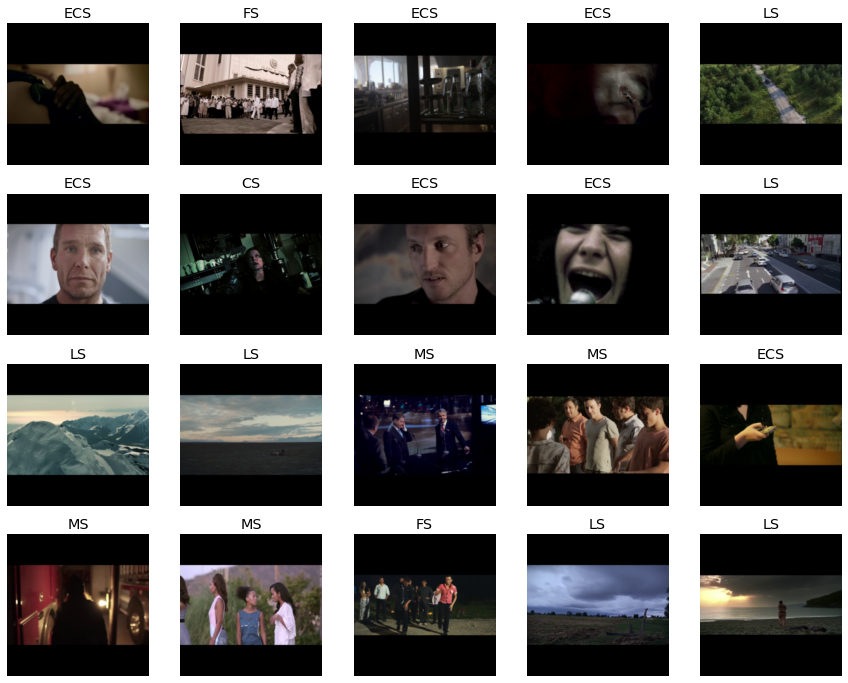

In [8]:
dls.valid.show_batch(max_n=20, nrows=4)

# Learn Dataloader

In [ ]:
# define learn

In [10]:
learn = cnn_learner(dls, resnet50, metrics=error_rate)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to C:\Users\Admin/.cache\torch\hub\checkpoints\resnet50-19c8e357.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

In [ ]:
# start learning

In [27]:
learn.fine_tune(4)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to C:\Users\WORK/.cache\torch\hub\checkpoints\resnet50-19c8e357.pth


epoch,train_loss,valid_loss,error_rate,time
0,0.741833,0.594429,0.229123,57:53


epoch,train_loss,valid_loss,error_rate,time
0,0.539731,0.459974,0.173848,1:06:41
1,0.473808,0.440554,0.161961,1:08:40
2,0.301741,0.440461,0.160178,1:10:09
3,0.161269,0.509980,0.158098,1:11:39


In [ ]:
# check confusion matrix

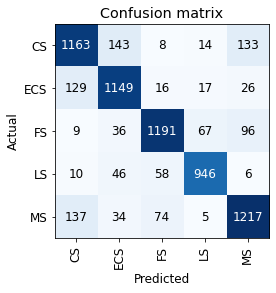

In [28]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

# Save Model

In [11]:
os.chdir(r'C:\Users\WORK\Documents\Jupyter')
learn.save('test')

# Load Model

In [20]:
os.chdir(r'C:\Users\Admin\Documents\Jupyter')
model=learn.load('test')
learn_inf = model

# Test Model

In [21]:
btn_upload = widgets.FileUpload()
print('Upload a shot PNG')
btn_upload

Upload a shot PNG


FileUpload(value={}, description='Upload')

Prediction: CS; Probability: 0.9985


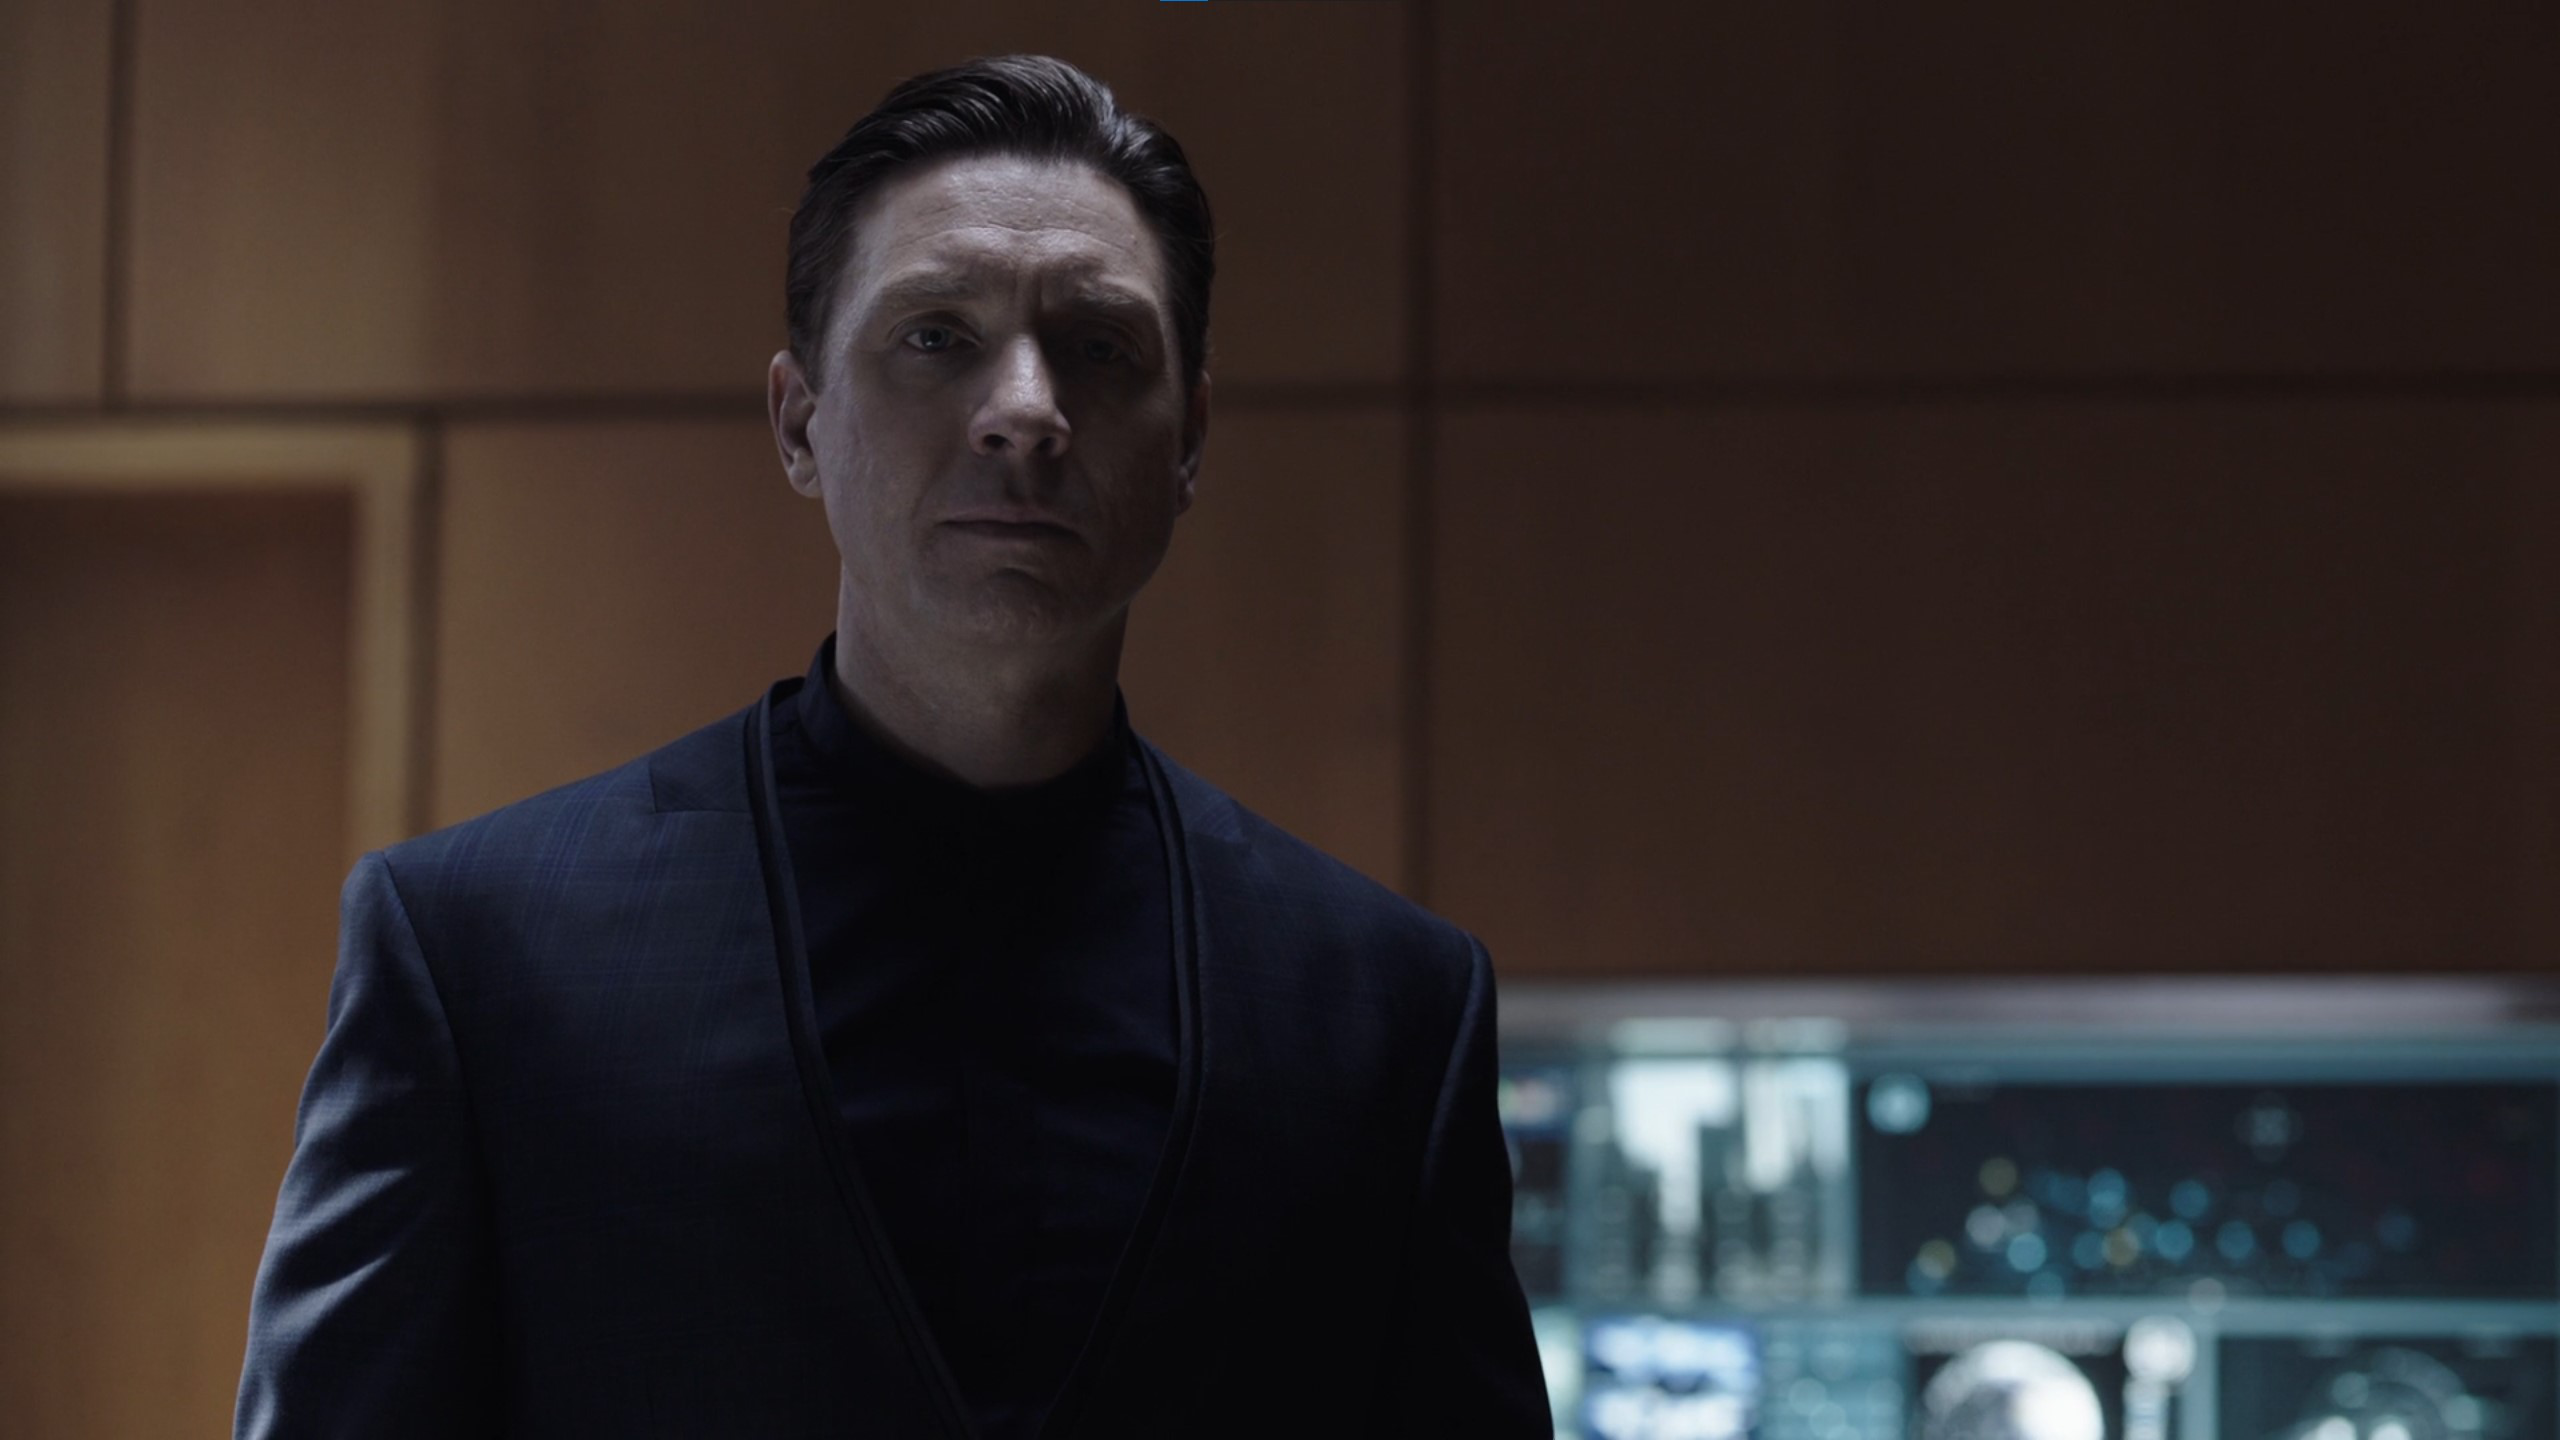

In [22]:
lbl_pred = widgets.Label()
img = PILImage.create(btn_upload.data[-1])
pred,pred_idx,probs = learn_inf.predict(img)
lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'
#btn_run
print(lbl_pred.value)
img

# Run Model on Scene

In [174]:
# function for cut detect

In [25]:
def extract_frame(video):
    creat_video_dir = video.replace('.mp4', '')
    if not os.path.exists(creat_video_dir):
                os.makedirs(creat_video_dir)
    command = f"ffmpeg -i {video} -vf select='gt(scene\,0.2)' -vsync vfr {creat_video_dir}/cut%04d.png"
    subprocess.call(command,shell=True)

In [195]:
# split mp4 by cut into dir by mp4 name

In [33]:
os.chdir(r'C:\Users\WORK\Documents\Jupyter\video')
clip = 'dead_poets_society.mp4'   # test on: the_big_lebowski , blade_runner , revenge
picture_of_cuts = extract_frame(clip)

In [ ]:
# make predictions on cuts by order

In [34]:
cut_path = clip.replace('.mp4', '')
shot_count=0
lbl_pred = widgets.Label()
#the_big_lebowski_cut_list = [cut_path]
#the_shining_cut_list = [cut_path]
#se7en_cut_list = [cut_path]
#blade_runner_cut_list = [cut_path]
#the_prestige_cut_list = [cut_path]
#goodfellas_cut_list = [cut_path]
#the_shawshank_redemption_cut_list = [cut_path]
#vertigo_cut_list = [cut_path]
#chinatown_cut_list = [cut_path]
#rear_window_cut_list = [cut_path]
dead_poets_society_cut_list = [cut_path]
for root, dirs, files in os.walk(cut_path):
    for name in files:
        if name.endswith((".png")):
            filename = cut_path + "\\" + name
            file = open(filename, 'rb')
            image = file.read()
            img = PILImage.create(image)
            pred,pred_idx,probs = learn_inf.predict(img)
            lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'
            shot_count = shot_count + 1
            dead_poets_society_cut_list.append([shot_count, pred])
            #rear_window_cut_list.append([shot_count, pred])
            #chinatown_cut_list.append([shot_count, pred])
            #vertigo_cut_list.append([shot_count, pred])
            #the_shawshank_redemption_cut_list.append([shot_count, pred])
            #goodfellas_cut_list.append([shot_count, pred])
            #the_prestige_cut_list.append([shot_count, pred])
            #the_big_lebowski_cut_list.append([shot_count, pred])
            #the_shining_cut_list.append([shot_count, pred])
            #se7en_cut_list.append([shot_count, pred])
            #blade_runner_cut_list.append([shot_count, pred])
            #print('Shot #' + str(shot_count))
            #print(lbl_pred.value)
            #img_show = mpimg.imread(cut_path + "\\" + name)
            #mgplot = plt.imshow(img_show)
            #plt.axis('off')
            #plt.show()

In [ ]:
# The Big Lebowski num shot and shot size

In [46]:
print(the_big_lebowski_cut_list)

['the_big_lebowski', [1, 'FS'], [2, 'MS'], [3, 'CS'], [4, 'MS'], [5, 'CS'], [6, 'MS'], [7, 'CS'], [8, 'MS'], [9, 'CS'], [10, 'MS'], [11, 'MS'], [12, 'FS'], [13, 'MS'], [14, 'MS'], [15, 'MS'], [16, 'MS'], [17, 'MS'], [18, 'MS'], [19, 'MS'], [20, 'MS'], [21, 'MS'], [22, 'MS'], [23, 'MS'], [24, 'MS'], [25, 'MS'], [26, 'MS'], [27, 'MS'], [28, 'MS'], [29, 'CS'], [30, 'MS'], [31, 'MS'], [32, 'MS'], [33, 'MS'], [34, 'MS'], [35, 'MS'], [36, 'CS'], [37, 'MS'], [38, 'CS'], [39, 'FS']]


In [ ]:
# Blade Runner num shot and shot size

In [21]:
print(blade_runner_cut_list)

['blade_runner', [1, 'CS'], [2, 'ECS'], [3, 'ECS'], [4, 'CS'], [5, 'FS'], [6, 'ECS'], [7, 'MS'], [8, 'MS'], [9, 'MS'], [10, 'MS'], [11, 'MS'], [12, 'MS'], [13, 'CS'], [14, 'CS'], [15, 'CS'], [16, 'CS'], [17, 'CS'], [18, 'CS'], [19, 'CS'], [20, 'CS'], [21, 'CS'], [22, 'CS'], [23, 'CS'], [24, 'CS'], [25, 'CS'], [26, 'CS'], [27, 'CS'], [28, 'CS'], [29, 'CS'], [30, 'CS'], [31, 'CS'], [32, 'CS'], [33, 'CS'], [34, 'CS'], [35, 'FS'], [36, 'MS'], [37, 'MS'], [38, 'MS'], [39, 'MS'], [40, 'MS']]


In [ ]:
# The Shining num shot and shot size full movie

In [38]:
print(the_shining_cut_list)

['the_shining', [1, 'LS'], [2, 'LS'], [3, 'LS'], [4, 'LS'], [5, 'LS'], [6, 'FS'], [7, 'FS'], [8, 'MS'], [9, 'CS'], [10, 'CS'], [11, 'CS'], [12, 'CS'], [13, 'CS'], [14, 'CS'], [15, 'CS'], [16, 'FS'], [17, 'MS'], [18, 'CS'], [19, 'MS'], [20, 'CS'], [21, 'MS'], [22, 'CS'], [23, 'MS'], [24, 'CS'], [25, 'MS'], [26, 'CS'], [27, 'MS'], [28, 'CS'], [29, 'MS'], [30, 'MS'], [31, 'CS'], [32, 'MS'], [33, 'CS'], [34, 'MS'], [35, 'CS'], [36, 'MS'], [37, 'CS'], [38, 'MS'], [39, 'FS'], [40, 'MS'], [41, 'FS'], [42, 'MS'], [43, 'FS'], [44, 'MS'], [45, 'FS'], [46, 'ECS'], [47, 'FS'], [48, 'CS'], [49, 'CS'], [50, 'FS'], [51, 'CS'], [52, 'FS'], [53, 'CS'], [54, 'FS'], [55, 'FS'], [56, 'FS'], [57, 'FS'], [58, 'MS'], [59, 'FS'], [60, 'FS'], [61, 'FS'], [62, 'MS'], [63, 'MS'], [64, 'CS'], [65, 'FS'], [66, 'FS'], [67, 'CS'], [68, 'CS'], [69, 'CS'], [70, 'CS'], [71, 'CS'], [72, 'CS'], [73, 'CS'], [74, 'CS'], [75, 'MS'], [76, 'CS'], [77, 'CS'], [78, 'CS'], [79, 'CS'], [80, 'CS'], [81, 'CS'], [82, 'CS'], [83, 'CS

In [ ]:
# Se7en num shot and shot size full movie

In [43]:
print(se7en_cut_list)

['se7en', [1, 'LS'], [2, 'MS'], [3, 'MS'], [4, 'ECS'], [5, 'MS'], [6, 'CS'], [7, 'MS'], [8, 'MS'], [9, 'FS'], [10, 'ECS'], [11, 'CS'], [12, 'CS'], [13, 'CS'], [14, 'MS'], [15, 'CS'], [16, 'MS'], [17, 'ECS'], [18, 'MS'], [19, 'CS'], [20, 'MS'], [21, 'MS'], [22, 'CS'], [23, 'MS'], [24, 'FS'], [25, 'MS'], [26, 'MS'], [27, 'FS'], [28, 'MS'], [29, 'MS'], [30, 'MS'], [31, 'MS'], [32, 'CS'], [33, 'MS'], [34, 'MS'], [35, 'MS'], [36, 'CS'], [37, 'MS'], [38, 'MS'], [39, 'FS'], [40, 'MS'], [41, 'MS'], [42, 'CS'], [43, 'MS'], [44, 'MS'], [45, 'CS'], [46, 'MS'], [47, 'CS'], [48, 'MS'], [49, 'CS'], [50, 'MS'], [51, 'MS'], [52, 'CS'], [53, 'MS'], [54, 'CS'], [55, 'FS'], [56, 'MS'], [57, 'MS'], [58, 'MS'], [59, 'CS'], [60, 'CS'], [61, 'CS'], [62, 'FS'], [63, 'MS'], [64, 'FS'], [65, 'FS'], [66, 'FS'], [67, 'MS'], [68, 'MS'], [69, 'MS'], [70, 'MS'], [71, 'ECS'], [72, 'MS'], [73, 'CS'], [74, 'CS'], [75, 'CS'], [76, 'FS'], [77, 'MS'], [78, 'CS'], [79, 'FS'], [80, 'MS'], [81, 'CS'], [82, 'CS'], [83, 'MS'],

In [ ]:
# The Prestige num shot and shot size full movie

In [12]:
print(the_prestige_cut_list)

['the_prestige', [1, 'CS'], [2, 'ECS'], [3, 'ECS'], [4, 'CS'], [5, 'CS'], [6, 'MS'], [7, 'CS'], [8, 'CS'], [9, 'MS'], [10, 'MS'], [11, 'CS'], [12, 'CS'], [13, 'CS'], [14, 'CS'], [15, 'CS'], [16, 'CS'], [17, 'MS'], [18, 'CS'], [19, 'FS'], [20, 'CS'], [21, 'FS'], [22, 'CS'], [23, 'CS'], [24, 'MS'], [25, 'CS'], [26, 'CS'], [27, 'CS'], [28, 'FS'], [29, 'CS'], [30, 'ECS'], [31, 'CS'], [32, 'FS'], [33, 'MS'], [34, 'CS'], [35, 'CS'], [36, 'MS'], [37, 'MS'], [38, 'CS'], [39, 'FS'], [40, 'CS'], [41, 'MS'], [42, 'CS'], [43, 'CS'], [44, 'MS'], [45, 'CS'], [46, 'MS'], [47, 'CS'], [48, 'MS'], [49, 'FS'], [50, 'CS'], [51, 'CS'], [52, 'CS'], [53, 'MS'], [54, 'LS'], [55, 'ECS'], [56, 'ECS'], [57, 'ECS'], [58, 'CS'], [59, 'ECS'], [60, 'ECS'], [61, 'CS'], [62, 'MS'], [63, 'CS'], [64, 'LS'], [65, 'FS'], [66, 'CS'], [67, 'CS'], [68, 'CS'], [69, 'CS'], [70, 'CS'], [71, 'CS'], [72, 'FS'], [73, 'FS'], [74, 'MS'], [75, 'MS'], [76, 'MS'], [77, 'FS'], [78, 'MS'], [79, 'CS'], [80, 'MS'], [81, 'LS'], [82, 'LS'], 

In [ ]:
# Goodfellas num shot and shot size full movie

In [16]:
print(goodfellas_cut_list)

['goodfellas', [1, 'MS'], [2, 'CS'], [3, 'CS'], [4, 'MS'], [5, 'FS'], [6, 'FS'], [7, 'LS'], [8, 'MS'], [9, 'FS'], [10, 'MS'], [11, 'MS'], [12, 'MS'], [13, 'MS'], [14, 'FS'], [15, 'ECS'], [16, 'ECS'], [17, 'MS'], [18, 'MS'], [19, 'CS'], [20, 'CS'], [21, 'ECS'], [22, 'CS'], [23, 'CS'], [24, 'CS'], [25, 'CS'], [26, 'MS'], [27, 'FS'], [28, 'FS'], [29, 'FS'], [30, 'MS'], [31, 'MS'], [32, 'MS'], [33, 'MS'], [34, 'MS'], [35, 'CS'], [36, 'MS'], [37, 'CS'], [38, 'FS'], [39, 'FS'], [40, 'MS'], [41, 'MS'], [42, 'MS'], [43, 'LS'], [44, 'ECS'], [45, 'MS'], [46, 'MS'], [47, 'MS'], [48, 'MS'], [49, 'FS'], [50, 'MS'], [51, 'ECS'], [52, 'MS'], [53, 'FS'], [54, 'ECS'], [55, 'FS'], [56, 'MS'], [57, 'FS'], [58, 'CS'], [59, 'CS'], [60, 'CS'], [61, 'MS'], [62, 'CS'], [63, 'MS'], [64, 'FS'], [65, 'FS'], [66, 'LS'], [67, 'ECS'], [68, 'MS'], [69, 'CS'], [70, 'MS'], [71, 'CS'], [72, 'CS'], [73, 'CS'], [74, 'CS'], [75, 'CS'], [76, 'CS'], [77, 'CS'], [78, 'CS'], [79, 'CS'], [80, 'CS'], [81, 'CS'], [82, 'CS'], [83

In [19]:
print(the_shawshank_redemption_cut_list)

['the_shawshank_redemption', [1, 'ECS'], [2, 'CS'], [3, 'MS'], [4, 'CS'], [5, 'ECS'], [6, 'CS'], [7, 'ECS'], [8, 'CS'], [9, 'CS'], [10, 'CS'], [11, 'CS'], [12, 'MS'], [13, 'CS'], [14, 'ECS'], [15, 'CS'], [16, 'ECS'], [17, 'CS'], [18, 'ECS'], [19, 'MS'], [20, 'CS'], [21, 'MS'], [22, 'MS'], [23, 'CS'], [24, 'FS'], [25, 'MS'], [26, 'MS'], [27, 'MS'], [28, 'FS'], [29, 'FS'], [30, 'MS'], [31, 'CS'], [32, 'CS'], [33, 'MS'], [34, 'CS'], [35, 'FS'], [36, 'FS'], [37, 'MS'], [38, 'FS'], [39, 'FS'], [40, 'CS'], [41, 'FS'], [42, 'ECS'], [43, 'MS'], [44, 'MS'], [45, 'CS'], [46, 'MS'], [47, 'MS'], [48, 'CS'], [49, 'MS'], [50, 'CS'], [51, 'MS'], [52, 'MS'], [53, 'MS'], [54, 'MS'], [55, 'MS'], [56, 'MS'], [57, 'CS'], [58, 'MS'], [59, 'MS'], [60, 'CS'], [61, 'CS'], [62, 'CS'], [63, 'MS'], [64, 'MS'], [65, 'CS'], [66, 'CS'], [67, 'CS'], [68, 'FS'], [69, 'CS'], [70, 'MS'], [71, 'FS'], [72, 'CS'], [73, 'CS'], [74, 'FS'], [75, 'CS'], [76, 'CS'], [77, 'MS'], [78, 'CS'], [79, 'CS'], [80, 'CS'], [81, 'CS'], [

In [28]:
print(chinatown_cut_list)

['chinatown', [1, 'CS'], [2, 'MS'], [3, 'CS'], [4, 'MS'], [5, 'FS'], [6, 'CS'], [7, 'MS'], [8, 'CS'], [9, 'MS'], [10, 'CS'], [11, 'MS'], [12, 'MS'], [13, 'MS'], [14, 'MS'], [15, 'CS'], [16, 'CS'], [17, 'MS'], [18, 'MS'], [19, 'CS'], [20, 'CS'], [21, 'FS'], [22, 'CS'], [23, 'MS'], [24, 'CS'], [25, 'CS'], [26, 'MS'], [27, 'MS'], [28, 'FS'], [29, 'MS'], [30, 'CS'], [31, 'CS'], [32, 'MS'], [33, 'CS'], [34, 'FS'], [35, 'CS'], [36, 'FS'], [37, 'MS'], [38, 'FS'], [39, 'MS'], [40, 'CS'], [41, 'MS'], [42, 'LS'], [43, 'ECS'], [44, 'CS'], [45, 'FS'], [46, 'CS'], [47, 'ECS'], [48, 'MS'], [49, 'CS'], [50, 'FS'], [51, 'CS'], [52, 'MS'], [53, 'MS'], [54, 'LS'], [55, 'CS'], [56, 'CS'], [57, 'LS'], [58, 'LS'], [59, 'CS'], [60, 'LS'], [61, 'ECS'], [62, 'MS'], [63, 'ECS'], [64, 'FS'], [65, 'ECS'], [66, 'CS'], [67, 'ECS'], [68, 'MS'], [69, 'FS'], [70, 'MS'], [71, 'MS'], [72, 'MS'], [73, 'FS'], [74, 'CS'], [75, 'CS'], [76, 'ECS'], [77, 'MS'], [78, 'ECS'], [79, 'MS'], [80, 'LS'], [81, 'CS'], [82, 'MS'], [83

In [32]:
print(rear_window_cut_list)

['rear_window', [1, 'ECS'], [2, 'ECS'], [3, 'FS'], [4, 'FS'], [5, 'MS'], [6, 'FS'], [7, 'CS'], [8, 'FS'], [9, 'CS'], [10, 'FS'], [11, 'CS'], [12, 'FS'], [13, 'CS'], [14, 'FS'], [15, 'CS'], [16, 'FS'], [17, 'CS'], [18, 'FS'], [19, 'CS'], [20, 'FS'], [21, 'CS'], [22, 'FS'], [23, 'CS'], [24, 'FS'], [25, 'CS'], [26, 'FS'], [27, 'CS'], [28, 'FS'], [29, 'MS'], [30, 'FS'], [31, 'CS'], [32, 'FS'], [33, 'CS'], [34, 'FS'], [35, 'CS'], [36, 'FS'], [37, 'LS'], [38, 'FS'], [39, 'CS'], [40, 'FS'], [41, 'CS'], [42, 'FS'], [43, 'MS'], [44, 'CS'], [45, 'MS'], [46, 'MS'], [47, 'MS'], [48, 'CS'], [49, 'CS'], [50, 'CS'], [51, 'CS'], [52, 'CS'], [53, 'CS'], [54, 'CS'], [55, 'MS'], [56, 'MS'], [57, 'MS'], [58, 'MS'], [59, 'MS'], [60, 'MS'], [61, 'MS'], [62, 'CS'], [63, 'MS'], [64, 'CS'], [65, 'MS'], [66, 'CS'], [67, 'FS'], [68, 'CS'], [69, 'FS'], [70, 'CS'], [71, 'FS'], [72, 'CS'], [73, 'FS'], [74, 'CS'], [75, 'FS'], [76, 'CS'], [77, 'FS'], [78, 'CS'], [79, 'MS'], [80, 'CS'], [81, 'FS'], [82, 'MS'], [83, 'C

In [32]:
print(dead_poets_society_cut_list)

['rear_window', [1, 'ECS'], [2, 'ECS'], [3, 'FS'], [4, 'FS'], [5, 'MS'], [6, 'FS'], [7, 'CS'], [8, 'FS'], [9, 'CS'], [10, 'FS'], [11, 'CS'], [12, 'FS'], [13, 'CS'], [14, 'FS'], [15, 'CS'], [16, 'FS'], [17, 'CS'], [18, 'FS'], [19, 'CS'], [20, 'FS'], [21, 'CS'], [22, 'FS'], [23, 'CS'], [24, 'FS'], [25, 'CS'], [26, 'FS'], [27, 'CS'], [28, 'FS'], [29, 'MS'], [30, 'FS'], [31, 'CS'], [32, 'FS'], [33, 'CS'], [34, 'FS'], [35, 'CS'], [36, 'FS'], [37, 'LS'], [38, 'FS'], [39, 'CS'], [40, 'FS'], [41, 'CS'], [42, 'FS'], [43, 'MS'], [44, 'CS'], [45, 'MS'], [46, 'MS'], [47, 'MS'], [48, 'CS'], [49, 'CS'], [50, 'CS'], [51, 'CS'], [52, 'CS'], [53, 'CS'], [54, 'CS'], [55, 'MS'], [56, 'MS'], [57, 'MS'], [58, 'MS'], [59, 'MS'], [60, 'MS'], [61, 'MS'], [62, 'CS'], [63, 'MS'], [64, 'CS'], [65, 'MS'], [66, 'CS'], [67, 'FS'], [68, 'CS'], [69, 'FS'], [70, 'CS'], [71, 'FS'], [72, 'CS'], [73, 'FS'], [74, 'CS'], [75, 'FS'], [76, 'CS'], [77, 'FS'], [78, 'CS'], [79, 'MS'], [80, 'CS'], [81, 'FS'], [82, 'MS'], [83, 'C

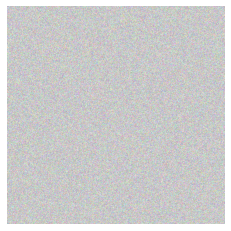

In [28]:
sz = 500
test_img = np.uint8(np.random.uniform(150, 250, (sz, sz, 3)))/255
mgplot = plt.imshow(test_img)
plt.axis('off')
plt.show()